# Sequential probability ratio test for permutations

## General Bernoulli SPRT

Suppose we observe independent, equiprobable events $X_1, X_2, \dots$, where $X_n$ is an indicator for whether the $n$th event occurred or not. Each indicator has a Bernoulli distribution with some probability $p$. We'd like to test the null hypothesis $H_0: p = p_0$ against the alternative $H_1: p = p_1 > p_0$. Wald's sequential probability ratio test (SPRT) is a hypothesis testing procedure, based on iteratively updating the likelihood ratio for the data after each observation, and reaching a decision once the likelihood ratio passes some threshold.

#### Procedure

Set $\mbox{LR}_0 \leftarrow 1$ and $j \leftarrow 0$.

 + Increment $j$
 + If $X_j = 1$, $\mbox{LR}_j \leftarrow \mbox{LR}_{j-1} \times p_1/p_0$. 
 + If $X_j = 0$, $\mbox{LR}_j \leftarrow \mbox{LR}_{j-1} \times (1-p_1)/(1- p_0)$.

Conclude $p > p_0$ (reject the null hypothesis) if 
$$\mbox{LR}_j  \ge \frac{1-\beta}{\alpha}.$$
Conclude $p \le p_0$ (fail to reject the null hypothesis) if
$$ \mbox{LR}_j  \le \frac{\beta}{1-\alpha}.$$
Otherwise, draw again.

#### Properties of the test

For any $\alpha \in (0, 1)$ and $\beta \in [0, 1)$, the sequential algorithm above tests the hypothesis $H_0$ at level no larger than $\alpha$ and with power at least $1-\beta$ against the alternative $H_1$.

In particular, Wald (1945) showed that if $H_0$ is true, then the probability is at most $\alpha$ that the likelihood ratio is ever greater than $1/\alpha$, no matter how many observations are made. If we set $\beta = 0$, then the likelihood ratio when we stop the test can be interpreted as a $p$-value.

The SPRT approximately minimizes the  expected sample size when $p \le p_0$ or $p > p_1$.
For values in $(p_1, p_0)$, it can have larger sample sizes than fixed-sample-size tests.

## Derangements

A derangement is a permutation that leaves no item fixed. For instance, if we permute the vector $(1, 2, 3, 4)$, then $(2, 3, 4, 1)$ is a derangement but $(1, 3, 4, 2)$ is not. We will base a SPRT on the frequency of derangements when we use a particular PRNG and sampling algorithm. If all permutations occur with equal frequency, then the probability that a permutation is a derangement is given by $p_0 = \frac{D_n}{n!}$, where $D_n$ is the number of derangements of $n$ items. To compute this probability under the null hypothesis, we need to count $D_n$.

Let $A_p$ denote the set of permutations of $n$ items that fix the $p$th item, for $p=1,\dots,n$. The set of derangements is the complement of the union of these sets, so $D_n = n! - \lvert \cup_{p=1}^n A_p \rvert$. Using the inclusion-exclusion principle, we have

\begin{align*}
\lvert \cup_{p=1}^n A_p \rvert &= \sum_{p=1}^n \lvert A_p \rvert - \sum_{p < q} \lvert A_p \cap A_q \rvert + \dots + (-1)^{n+1}\lvert \cap_{p=1}^n A_p \rvert \\
&= \text{# permutations fixing one item} - \text{# permutations fixing two items} + \dots + (-1)^{n+1} \text{ permutations fixing all items}
\end{align*}

The number of permutations fixing $p$ items is $(n-p)! {n \choose p}$ because after fixing $p$ points, we can freely permute $n-p$ of them, and there are ${n\choose p}$ subsets of $p$ points that we could fix. Plugging this back in, we get

\begin{align*}
D_n &= n! - (n-1)!{n \choose 1} + (n-2)!{n \choose 2} - \dots + (-1)^{n}{n \choose n} \\
\frac{D_n}{n!} &= 1 - \frac{1}{1!} + \frac{1}{2!} - \dots + \frac{(-1)^{n}}{n!} \\
&= \sum_{p=0}^n \frac{(-1)^{p}}{p!}
\end{align*}

This probability converges quickly to $e^{-1} \approx 0.3678794$, but differs somewhat for small $n$. We let $p_0 = \frac{D_n}{n!}$ and conduct the SPRT for whether derangements occur with this frequency.

## Simulation parameters

We compare three PRNGs (Mersenne Twister, Super Duper LCG, and SHA-256) and two permutation algorithms (permuting indices and the Fisher-Yates-Knuth-Durstenfeld shuffle). Throughout, we use a population of size $n=10$, for a total of $10! = 3,628,800$ possible multinomial categories. We specify $p_1 = 1.1p_0$. We use a type I error rate of $\alpha=0.05$ and type II error rate of $\beta = 0$; this ensures that we never accept the null hypothesis, but either reject it at level $\alpha$ or terminate after $10^7$ steps without making a decision.

## Summary of results

We tended to reject the null hypothesis around 5\% of the time for the three PRNGs when permuting indices. We never rejected when using FYKD shuffle. SHA-256 tended to require more steps to reject the null than the other two PRNGs.

In [1]:
library(dplyr)
library(ggplot2)
options(warn = (-1), message = (-1))


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
combinations <- expand.grid(c("MT", "SD", "SHA256"),
                            c("pi", "fykd"))

rawdatafiles <- list.files("../rawdata/")

res <- lapply(1:nrow(combinations), function(index){
  filename <- paste0(combinations[index, 1],
                     "_derangements_", combinations[index, 2], "_n10.csv")
  if(!(filename %in% rawdatafiles)){ return()}
  
  tmp <- read.csv(paste0("../rawdata/", filename), header = TRUE)
  tmp$PRNG <- rep(combinations[index, 1], nrow(tmp))
  tmp$algorithm <- rep(combinations[index, 2], nrow(tmp))
  return(tmp)
})
res <- do.call(rbind, res)

In [3]:
head(res)
str(res)

prng,algorithm,seed,decision,LR,pvalue,steps,PRNG
MT,pi,739828299,None,9.535467e-322,1,10000000,MT
MT,pi,3802979302,None,1.086944e-322,1,10000000,MT
MT,pi,2488119888,None,5.434722e-323,1,10000000,MT
MT,pi,2813529707,None,4.940656e-323,1,10000000,MT
MT,pi,564698376,None,5.434722e-323,1,10000000,MT
MT,pi,2114313936,None,4.446591e-323,1,10000000,MT


'data.frame':	6000 obs. of  8 variables:
 $ prng     : Factor w/ 3 levels "MT","SD","SHA256": 1 1 1 1 1 1 1 1 1 1 ...
 $ algorithm: Factor w/ 2 levels "pi","fykd": 1 1 1 1 1 1 1 1 1 1 ...
 $ seed     : num  7.40e+08 3.80e+09 2.49e+09 2.81e+09 5.65e+08 ...
 $ decision : Factor w/ 2 levels "1","None": 2 2 2 2 2 2 2 2 2 2 ...
 $ LR       : num  9.54e-322 1.09e-322 5.43e-323 4.94e-323 5.43e-323 ...
 $ pvalue   : num  1 1 1 1 1 1 1 1 1 1 ...
 $ steps    : int  10000000 10000000 10000000 10000000 10000000 10000000 10000000 10000000 10000000 10000000 ...
 $ PRNG     : Factor w/ 3 levels "MT","SD","SHA256": 1 1 1 1 1 1 1 1 1 1 ...


In [4]:
res %>% group_by(PRNG, algorithm) %>% summarise("Rejection rate" = mean(decision == "1"))

PRNG,algorithm,Rejection rate
MT,pi,0.044
MT,fykd,0.000
SD,pi,0.062
SD,fykd,0.000
SHA256,pi,0.056
SHA256,fykd,0.000


In [7]:
rejects <- res %>% filter(decision != "None")
rejects %>% group_by(PRNG, algorithm) %>% summarise("Mean steps" = mean(steps),
                                                    "Median steps" = median(steps),
                                                    "Min steps" = min(steps),
                                                    "Max steps" = max(steps))

PRNG,algorithm,Mean steps,Median steps,Min steps,Max steps
MT,pi,954.3864,782.0,99,2862
SD,pi,928.0323,642.0,196,4813
SHA256,pi,1022.4821,841.5,205,2803


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


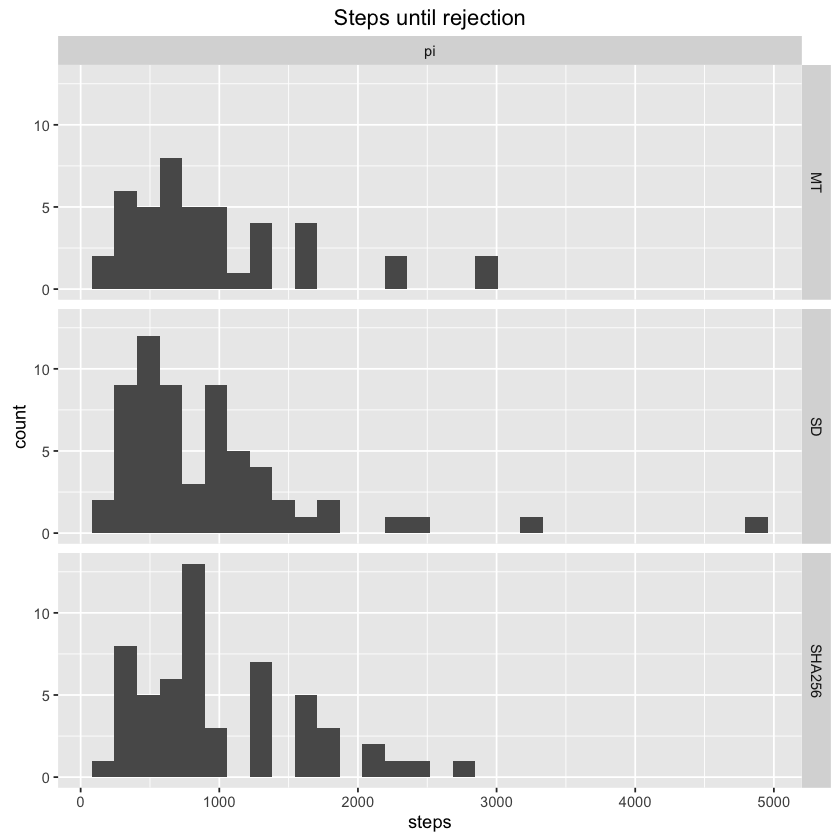

In [6]:
rejects %>% 
    ggplot(aes(steps)) + 
    geom_histogram() + 
    facet_grid(PRNG~algorithm) +
    ggtitle("Steps until rejection")